In [343]:
import numpy as np
import ssm
import matplotlib.pyplot as plt

from run import run_switching_experiment
from src.data.experiment_data import ExperimentData
from src.features.fit_curves import get_sigmoid_feats
from src.features.losses import mse_loss
from ssm.plots import gradient_cmap, white_to_color_cmap

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [344]:
expt_name = "constrained_run"
repo_path = "/Users/johnzhou/research/decision-making"
bigboy = ExperimentData(expt_name, repo_path)

In [345]:
config = OmegaConf.create({
    "name": expt_name,
    "random_seed": 4995,
    "model": {
        "in_features": 3,
        "linear_layers": [32, 8, 4],
        "use_batch_norm": False
    },
    "learning_rate": 1e-4,
    "data": {
        "feature_path": f"{bigboy.data_path}/modeling_features.npy",
        "label_path": f"{bigboy.data_path}/modeling_labels.npy",
        "train_proportion": 0.8,
        "train_batch_size": 128,
        "val_batch_size": 128
    },
    "trainer": {
        "gpus": 0,
        "max_epochs": 1000
    },

})

X_fname = f"{bigboy.data_path}/modeling_features.npy"
model_fname = f"{bigboy.data_path}/models/model.ckpt"
system = SigmoidNet(config)

model = system.load_from_checkpoint(model_fname)

LinearEmbedder(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.05)
    (2): Linear(in_features=32, out_features=8, bias=True)
    (3): LeakyReLU(negative_slope=0.05)
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): LeakyReLU(negative_slope=0.05)
    (6): Linear(in_features=4, out_features=2, bias=True)
  )
)
LinearEmbedder(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.05)
    (2): Linear(in_features=32, out_features=8, bias=True)
    (3): LeakyReLU(negative_slope=0.05)
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): LeakyReLU(negative_slope=0.05)
    (6): Linear(in_features=4, out_features=2, bias=True)
  )
)


In [356]:
trans_matrix = np.array([[0.70, 0.30],
                         [0.30, 0.70]])
trunc_actions, state_history = run_switching_experiment(trans_matrix, 
                                                        lr_bounds=(0.01, 1.4),
                                                        eps_bounds=(0.01, 0.4),
                                                        num_lrs=10,
                                                        num_eps=10,
                                                        pswitch_bounds=(0.01, 0.45),
                                                        prew_bounds=(0.55, 0.99),
                                                        num_pswitches=10,
                                                        num_prews=10,
                                                        num_blocks=100)

sigmoid_params = get_sigmoid_feats(trunc_actions, mse_loss, plot=False)
print(sigmoid_params.shape)

100%|██████████████████████████████████████████| 100/100 [00:00<00:00, 159.03it/s]

(100, 3)


In [357]:
embed_obs = torch.squeeze(model(torch.unsqueeze(torch.from_numpy(sigmoid_params).float(), 1))).detach().numpy()
print(embed_obs.shape)
true_states = np.array([state[0] for state in state_history])
print(true_states)

classified_obs = embed_obs[:, 0] < border
other_true_states = np.array([int(ob) for ob in classified_obs])
other_other_true_states = np.array(sigmoid_params[:, 0] < 0.001).astype(int)
print(other_other_true_states)
print(other_true_states)

time_bins = true_states.size
obs = sigmoid_params

(100, 2)
[1 1 1 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 1 1 0]
[1 0 1 0 1 1 0 1 1 0 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0
 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0 0 0 0 0]
[1 0 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 0 1 0 1 0
 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0]


idx: 0 [[0.         4.         0.49996314]]


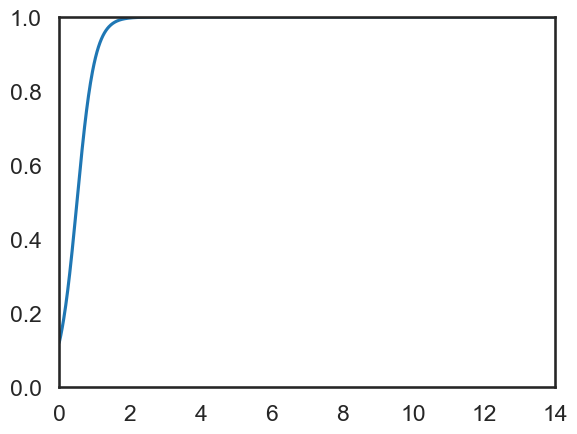

idx: 1 [[0.05766036 4.         0.49918106]]


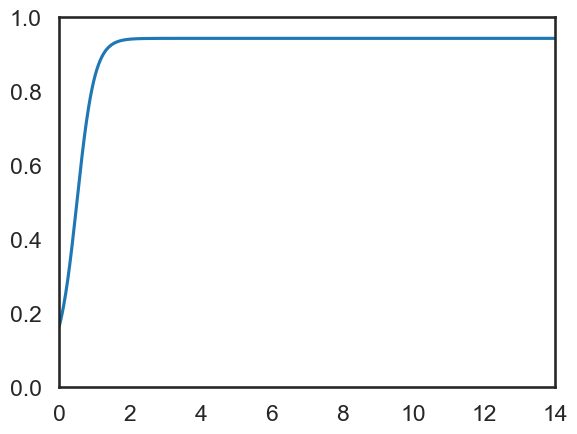

idx: 2 [[0.         4.         0.49996314]]


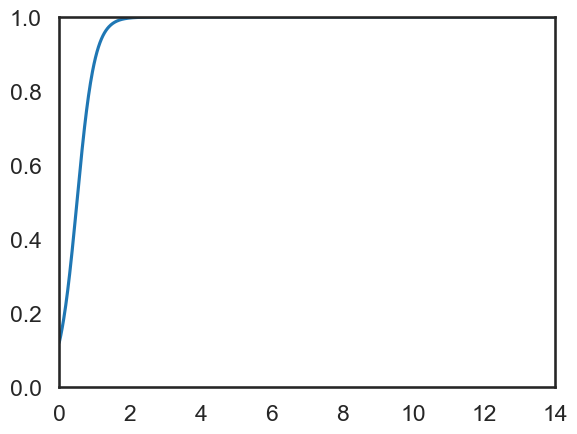

idx: 3 [[0.1283346  4.         0.49840989]]


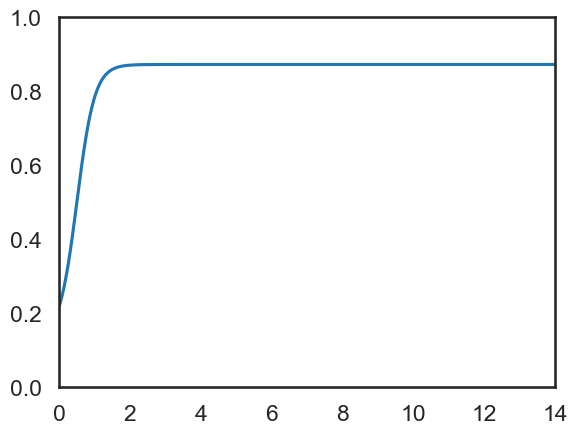

idx: 4 [[0.         4.         0.49996314]]


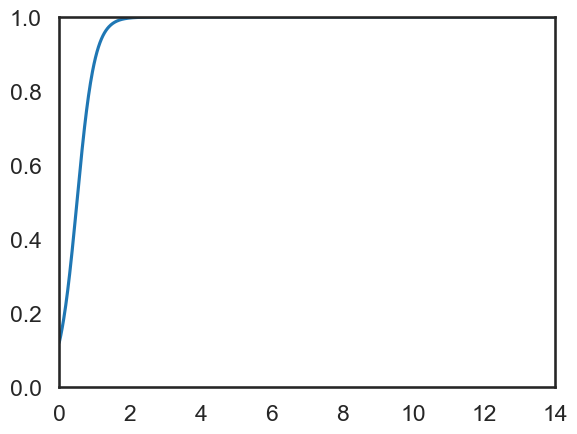

idx: 5 [[0.         4.         0.49996314]]


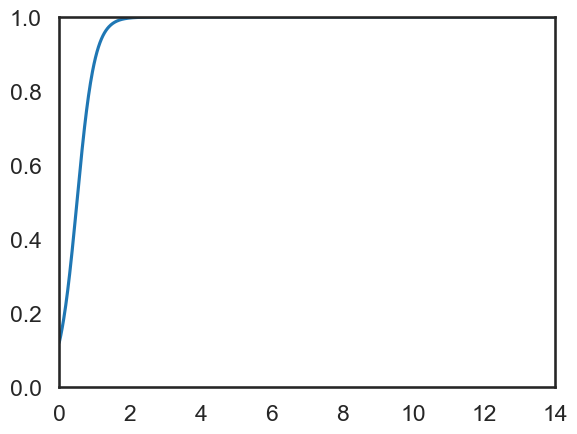

idx: 6 [[0.19897001 4.         1.49996348]]


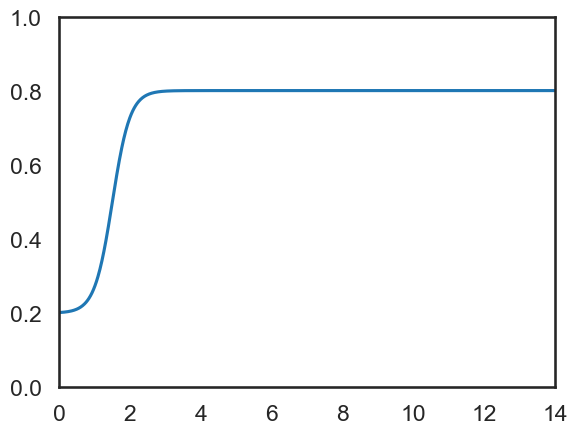

idx: 7 [[0.         0.84871771 1.41240871]]


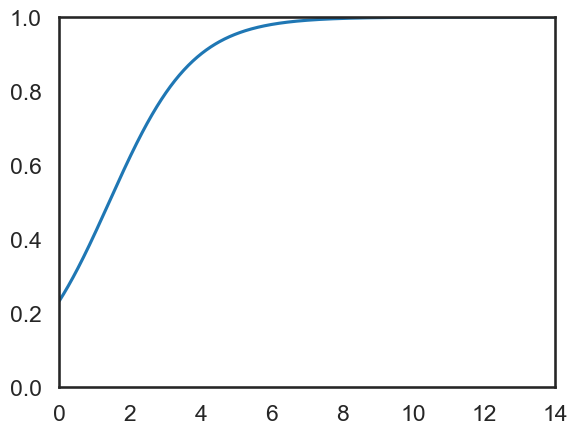

idx: 8 [[ 0.          0.49747751 -0.91258091]]


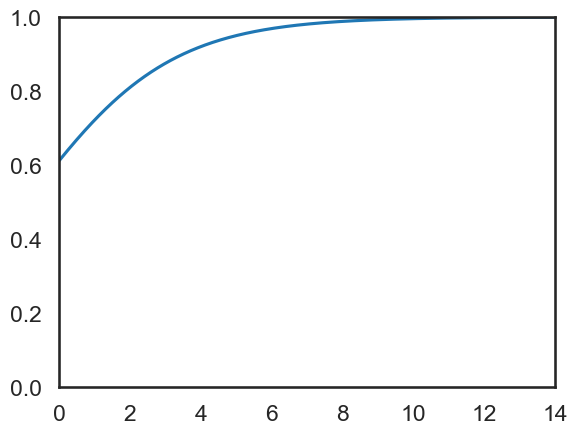

idx: 9 [[0.05752587 4.         2.50000115]]


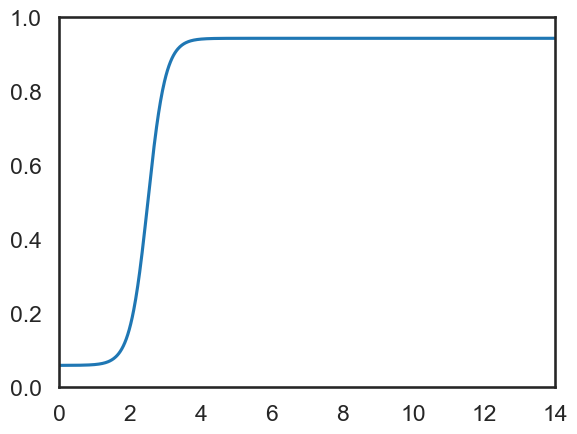

idx: 10 [[0.         4.         0.49996314]]


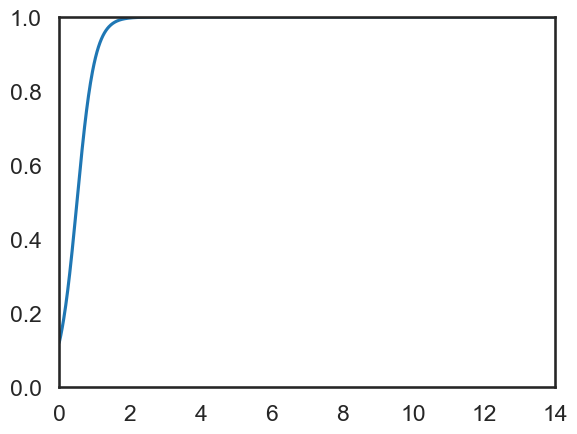

idx: 11 [[0.05752624 4.         3.50000001]]


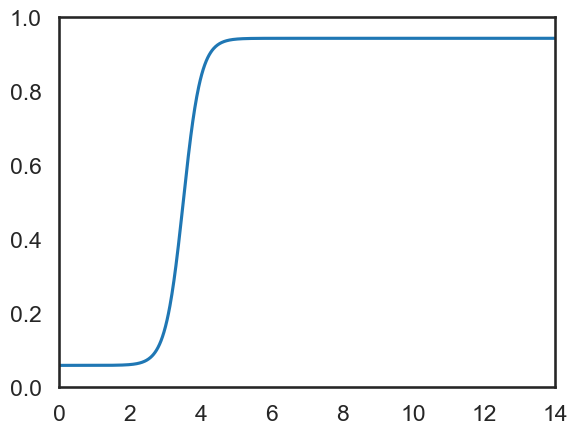

idx: 12 [[0.05751986 4.         2.50024728]]


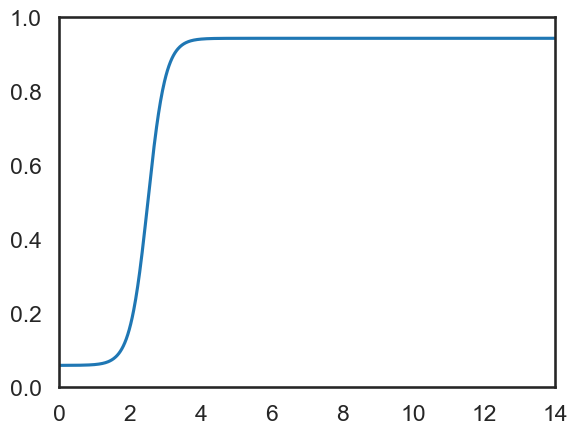

idx: 13 [[0.05766157 4.         0.49917741]]


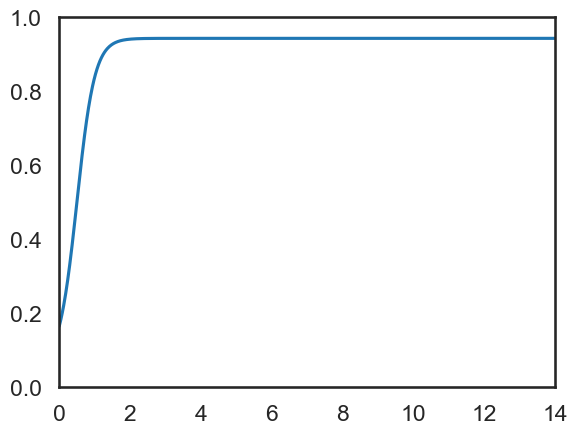

idx: 14 [[0.         4.         0.49996314]]


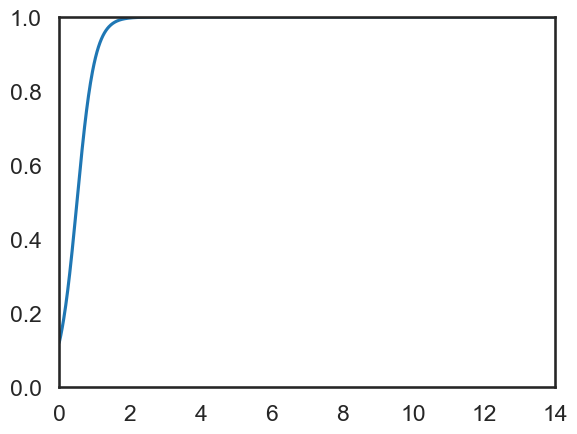

idx: 15 [[0.12824774 4.         2.4999967 ]]


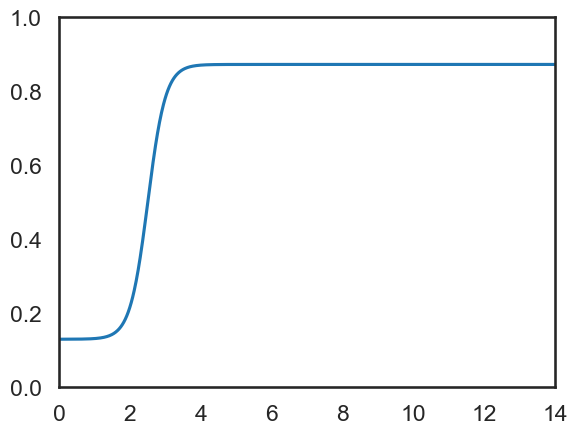

idx: 16 [[0.12824133 4.         2.50021818]]



KeyboardInterrupt



In [358]:
from src.visualization.plot_replications import plot_fitted_block, plot_sigmoids
from src.features.fit_curves import epsilon_sigmoid

for i in range(sigmoid_params.shape[0]):
    print("idx:", i, sigmoid_params[i:i+1, :])
    plot_sigmoids(epsilon_sigmoid, sigmoid_params[i:i+1, :])

In [359]:
num_states = 2
obs_dim = 3
obs_model = "gaussian"
N_iters = 1000
fit_method = "em"

hmm = ssm.HMM(num_states, obs_dim, observations=obs_model) 
hmm_lls = hmm.fit(obs, method=fit_method, num_em_iters=N_iters, init_method="kmeans")

LP: -244.3: 100%|██████████████████████████████| 100/100 [00:00<00:00, 175.34it/s]


In [360]:
invalid_low_s = sigmoid_params[:, 2] < 0
invalid_high_s = sigmoid_params[:, 2] > 14
invalid_idxs = np.argwhere(invalid_low_s | invalid_high_s)
a = [i[0] for i in invalid_idxs]

print(len(a))
print(other_true_states.shape)
print(hmm_z.shape)

6
(100,)
(50,)


[1 1 1 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 1 1 0]


([], [])

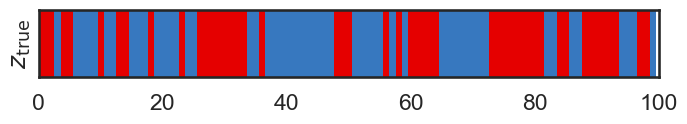

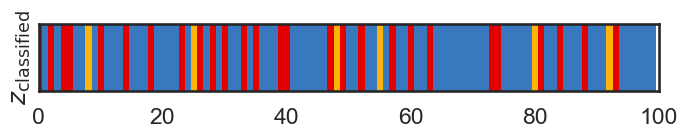

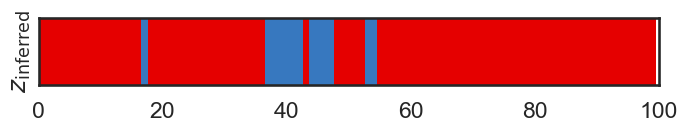

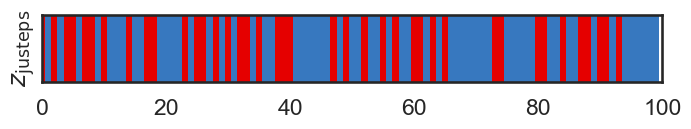

In [361]:
from ssm.util import find_permutation


most_likely_states = hmm.most_likely_states(obs)
print(true_states)
hmm.permute(find_permutation(true_states, most_likely_states))

hmm_z = hmm.most_likely_states(obs)

plt.figure(figsize=(8, 4))
plt.subplot(411)
plt.imshow(true_states[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, time_bins)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

other_true_states[a] = 2
plt.figure(figsize=(8, 4))
plt.subplot(412)
plt.imshow(other_true_states[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, time_bins)
plt.ylabel("$z_{\\mathrm{classified}}$")
plt.yticks([])

plt.figure(figsize=(8, 4))
plt.subplot(413)
plt.imshow(hmm_z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, time_bins)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])

plt.figure(figsize=(8, 4))
plt.subplot(414)
plt.imshow(other_other_true_states[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, time_bins)
plt.ylabel("$z_{\\mathrm{justeps}}$")
plt.yticks([])


In [352]:
most_likely_states = hmm.most_likely_states(obs)
print(true_states.shape)
hmm.permute(find_permutation(true_states, most_likely_states))

hmm_z = hmm.most_likely_states(obs)
plt.figure(figsize=(8, 4))
plt.subplot(411)
plt.imshow(hmm_z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, time_bins)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])

(50,)


AssertionError: All indices should have been matched!

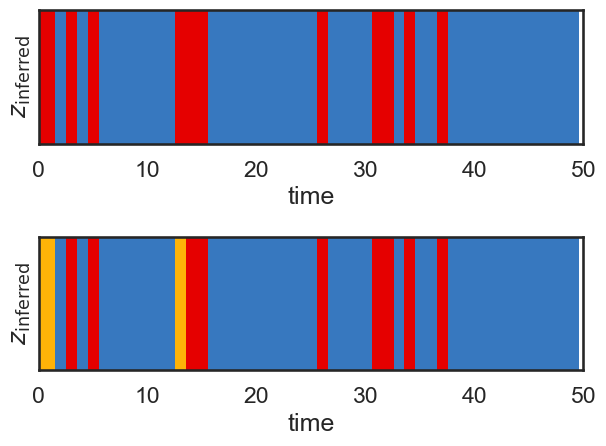

In [316]:
plt.subplot(211)
plt.imshow(hmm_z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, time_bins)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.subplot(212)
hmm_z[a] = 2
plt.imshow(hmm_z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, time_bins)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()

[[0.67786489 0.32213511]
 [0.05652513 0.94347487]]


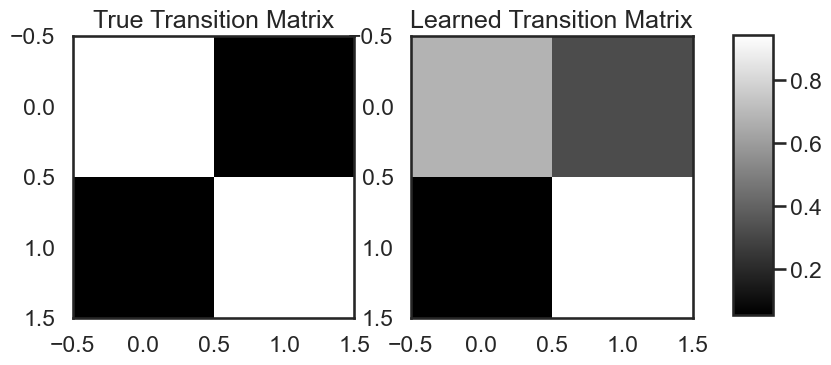

In [362]:
true_transition_mat = trans_matrix
learned_transition_mat = hmm.transitions.transition_matrix
print(learned_transition_mat)

fig = plt.figure(figsize=(8, 4))
plt.subplot(121)
im = plt.imshow(true_transition_mat, cmap='gray')
plt.title("True Transition Matrix")

plt.subplot(122)
im = plt.imshow(learned_transition_mat, cmap='gray')
plt.title("Learned Transition Matrix")

cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

# LDS for sigmoid params/

In [302]:
obs_dim = 3
state_dim = 2

assert(np.all(np.isfinite(obs)))

print("Fitting LDS with Laplace-EM using structured variational posterior")
lds = ssm.LDS(obs_dim, state_dim, emissions="gaussian")
elbos, q = lds.fit(obs, method="laplace_em", num_iters=1000)

# Get the posterior mean of the continuous states
state_means = q.mean_continuous_states[0]

# Smooth the data under the variational posterior
smoothed_obs = lds.smooth(state_means, obs)

Fitting LDS with Laplace-EM using structured variational posterior


ARHMM Initialization restarts:   0%|                        | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.



ELBO: -122.0: 100%|███████████████████████████| 1000/1000 [00:24<00:00, 40.22it/s]


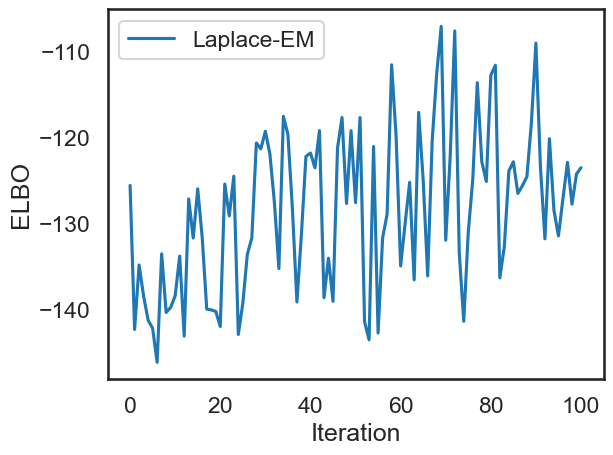

In [301]:
plt.plot(elbos, label="Laplace-EM")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.legend()

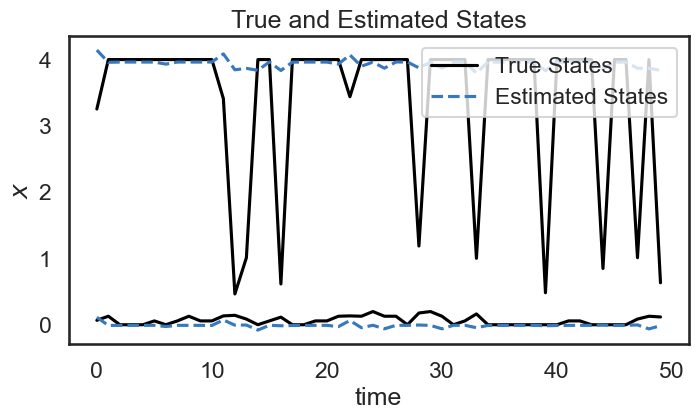

In [304]:
plt.figure(figsize=(8,4))
for d in range(state_dim):
    plt.plot(obs[:,d], '-k', label="True States" if d==0 else None)
    plt.plot(state_means[:,d] + 4 * d, '--', color=colors[0], label="Estimated States" if d==0 else None)
plt.ylabel("$x$")
plt.xlabel("time")
plt.legend(loc='upper right')
plt.title("True and Estimated States")
plt.show()